In [1]:
#import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import statistics as st
import keras
from imblearn.under_sampling import RandomUnderSampler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout
from tensorflow.python.keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report
#!{sys.executable} -m pip install keras

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/Cellar/jupy

# Preprocessing

In [2]:
"""
    Based on the training data given, we are able to extract 7 attributes:
    1. x accelerometer measurement
    2. y accelerometer measurement
    3. z accelerometer measurement
    4. x gyroscope measurement
    5. y gyroscope measurement
    6. z gyroscope measurement
    7. time stamp for accelerometer and gyroscope measures
    
    We start by creating a dataframe using the csv files provided for readability.
    
    @param x_file: contains the xyz accelerometers and xyz gyroscope measures from the lower limb
    @param x_time_file: contain the time stamps for the accelerometer and gyroscope measures
    @return dataframe of 7 attributes mentioned
"""
def create_dataframe_X(x_file, x_time_file):
    df1 = pd.read_csv(x_file, sep = ',', names = ['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr'])
    df2 = pd.read_csv(x_time_file, names = ['Time stamp'])
    frames = [df1, df2]
    result = pd.concat(frames, axis = 1)
    return result
    
"""
    We have both the labels and the time stamps for the labels. We create a dataframe from these for
    readability.
    
    @param y_file: contain the labels: 
        (0) indicates standing or walking in solid ground, 
        (1) indicates going down the stairs, 
        (2) indicates going up the stairs, and 
        (3) indicates walking on grass
    @param y_time_file: contain the time stamps for the labels
    @return dataframe of labels and time stamps
""" 
def create_dataframe_Y(y_file, y_time_file):
    df1 = pd.read_csv(y_file, names = ['Label'])
    df2 = pd.read_csv(y_time_file, names = ['Time stamp'])
    frames = [df1, df2]
    result = pd.concat(frames, axis = 1)
    return result
    
"""
    We take the outputs of create_dataframe_X and create_dataframe_Y. In order to combine both of these
    dataframes, we need look at the time intervals present for when the labels were assigned. The goal is
    to return a dataframe that now has an eighth column in addition to the seven columns from the dataframe
    from create_dataframe_X. Additionally, we know that x_frame contains more values than y_frame. We want to
    map these labels accordingly. In the end, we drop data points that have missing values.
    
    @param x_frame: dataframe from create_dataframe_X
    @param y_frame: dataframe from create_dataframe_Y
    @return dataframe with 8 columns (7 attributes and label)
"""
def combine_frames(x_frame, y_frame):
    # Change each dataframe column to a list for iterations
    labels = y_frame['Label'].tolist()
    time_stamp_y = y_frame['Time stamp'].tolist()
    time_stamp_x = x_frame['Time stamp'].tolist()
    
    labels_for_x = [] # Create empty list to gather corresponding labels for x_frame
    count = 0
    for i in range(0, len(time_stamp_y)):
        while (time_stamp_x[count] <= time_stamp_y[i]) and (count <= len(time_stamp_x)):
            labels_for_x.append(labels[i])
            count += 1
        continue
    
    # Concatenate the dataframes
    label_df = pd.DataFrame(labels_for_x, columns = ['Label']) # Convert list back to data frame
    combined_frame = pd.concat([x_frame, label_df], axis = 1)
    
    # Drop missing values at the end
    combined_frame = combined_frame.dropna()
    
    # Drop 'Time stamp' column
    combined_frame = combined_frame.drop(columns = ['Time stamp'])
    return combined_frame

In [3]:
"""
    Generating data frames from training data.
"""
# Subject_001_01
df_x_1_1 = create_dataframe_X('TrainingData/subject_001_01__x.csv', 'TrainingData/subject_001_01__x_time.csv')
df_y_1_1 = create_dataframe_Y('TrainingData/subject_001_01__y.csv', 'TrainingData/subject_001_01__y_time.csv')
frame_1_1 = combine_frames(df_x_1_1, df_y_1_1)

# Subject_001_02
df_x_1_2 = create_dataframe_X('TrainingData/subject_001_02__x.csv', 'TrainingData/subject_001_02__x_time.csv')
df_y_1_2 = create_dataframe_Y('TrainingData/subject_001_02__y.csv', 'TrainingData/subject_001_02__y_time.csv')
frame_1_2 = combine_frames(df_x_1_2, df_y_1_2)

# Subject_001_03
df_x_1_3 = create_dataframe_X('TrainingData/subject_001_03__x.csv', 'TrainingData/subject_001_03__x_time.csv')
df_y_1_3 = create_dataframe_Y('TrainingData/subject_001_03__y.csv', 'TrainingData/subject_001_03__y_time.csv')
frame_1_3 = combine_frames(df_x_1_3, df_y_1_3)

# Subject_001_04
df_x_1_4 = create_dataframe_X('TrainingData/subject_001_04__x.csv', 'TrainingData/subject_001_04__x_time.csv')
df_y_1_4 = create_dataframe_Y('TrainingData/subject_001_04__y.csv', 'TrainingData/subject_001_04__y_time.csv')
frame_1_4 = combine_frames(df_x_1_4, df_y_1_4)

# Subject_001_05
df_x_1_5 = create_dataframe_X('TrainingData/subject_001_05__x.csv', 'TrainingData/subject_001_05__x_time.csv')
df_y_1_5 = create_dataframe_Y('TrainingData/subject_001_05__y.csv', 'TrainingData/subject_001_05__y_time.csv')
frame_1_5 = combine_frames(df_x_1_5, df_y_1_5)

# Subject_001_06
df_x_1_6 = create_dataframe_X('TrainingData/subject_001_06__x.csv', 'TrainingData/subject_001_06__x_time.csv')
df_y_1_6 = create_dataframe_Y('TrainingData/subject_001_06__y.csv', 'TrainingData/subject_001_06__y_time.csv')
frame_1_6 = combine_frames(df_x_1_6, df_y_1_6)

# Subject_001_07
df_x_1_7 = create_dataframe_X('TrainingData/subject_001_07__x.csv', 'TrainingData/subject_001_07__x_time.csv')
df_y_1_7 = create_dataframe_Y('TrainingData/subject_001_07__y.csv', 'TrainingData/subject_001_07__y_time.csv')
frame_1_7 = combine_frames(df_x_1_7, df_y_1_7)

# Subject_001_08
df_x_1_8 = create_dataframe_X('TrainingData/subject_001_08__x.csv', 'TrainingData/subject_001_08__x_time.csv')
df_y_1_8 = create_dataframe_Y('TrainingData/subject_001_08__y.csv', 'TrainingData/subject_001_08__y_time.csv')
frame_1_8 = combine_frames(df_x_1_8, df_y_1_8)

# Subject_002_01
df_x_2_1 = create_dataframe_X('TrainingData/subject_002_01__x.csv', 'TrainingData/subject_002_01__x_time.csv')
df_y_2_1 = create_dataframe_Y('TrainingData/subject_002_01__y.csv', 'TrainingData/subject_002_01__y_time.csv')
frame_2_1 = combine_frames(df_x_2_1, df_y_2_1)

# Subject_002_02
df_x_2_2 = create_dataframe_X('TrainingData/subject_002_02__x.csv', 'TrainingData/subject_002_02__x_time.csv')
df_y_2_2 = create_dataframe_Y('TrainingData/subject_002_02__y.csv', 'TrainingData/subject_002_02__y_time.csv')
frame_2_2 = combine_frames(df_x_2_2, df_y_2_2)

# Subject_002_03
df_x_2_3 = create_dataframe_X('TrainingData/subject_002_03__x.csv', 'TrainingData/subject_002_03__x_time.csv')
df_y_2_3 = create_dataframe_Y('TrainingData/subject_002_03__y.csv', 'TrainingData/subject_002_03__y_time.csv')
frame_2_3 = combine_frames(df_x_2_3, df_y_2_3)

# Subject_002_04
df_x_2_4 = create_dataframe_X('TrainingData/subject_001_04__x.csv', 'TrainingData/subject_001_04__x_time.csv')
df_y_2_4 = create_dataframe_Y('TrainingData/subject_001_04__y.csv', 'TrainingData/subject_001_04__y_time.csv')
frame_2_4 = combine_frames(df_x_2_4, df_y_2_4)

# Subject_002_05
df_x_2_5 = create_dataframe_X('TrainingData/subject_002_05__x.csv', 'TrainingData/subject_002_05__x_time.csv')
df_y_2_5 = create_dataframe_Y('TrainingData/subject_002_05__y.csv', 'TrainingData/subject_002_05__y_time.csv')
frame_2_5 = combine_frames(df_x_2_5, df_y_2_5)

# Subject_003_01
df_x_3_1 = create_dataframe_X('TrainingData/subject_003_01__x.csv', 'TrainingData/subject_003_01__x_time.csv')
df_y_3_1 = create_dataframe_Y('TrainingData/subject_003_01__y.csv', 'TrainingData/subject_003_01__y_time.csv')
frame_3_1 = combine_frames(df_x_3_1, df_y_3_1)

# Subject_003_02
df_x_3_2 = create_dataframe_X('TrainingData/subject_003_02__x.csv', 'TrainingData/subject_003_02__x_time.csv')
df_y_3_2 = create_dataframe_Y('TrainingData/subject_003_02__y.csv', 'TrainingData/subject_003_02__y_time.csv')
frame_3_2 = combine_frames(df_x_3_2, df_y_3_2)

# Subject_003_03
df_x_3_3 = create_dataframe_X('TrainingData/subject_003_03__x.csv', 'TrainingData/subject_003_03__x_time.csv')
df_y_3_3 = create_dataframe_Y('TrainingData/subject_003_03__y.csv', 'TrainingData/subject_003_03__y_time.csv')
frame_3_3 = combine_frames(df_x_3_3, df_y_3_3)

# Subject_004_01
df_x_4_1 = create_dataframe_X('TrainingData/subject_004_01__x.csv', 'TrainingData/subject_004_01__x_time.csv')
df_y_4_1 = create_dataframe_Y('TrainingData/subject_004_01__y.csv', 'TrainingData/subject_004_01__y_time.csv')
frame_4_1 = combine_frames(df_x_4_1, df_y_4_1)

# Subject_004_02
df_x_4_2 = create_dataframe_X('TrainingData/subject_004_02__x.csv', 'TrainingData/subject_004_02__x_time.csv')
df_y_4_2 = create_dataframe_Y('TrainingData/subject_004_02__y.csv', 'TrainingData/subject_004_02__y_time.csv')
frame_4_2 = combine_frames(df_x_4_2, df_y_4_2)

# Subject_005_01
df_x_5_1 = create_dataframe_X('TrainingData/subject_005_01__x.csv', 'TrainingData/subject_005_01__x_time.csv')
df_y_5_1 = create_dataframe_Y('TrainingData/subject_005_01__y.csv', 'TrainingData/subject_005_01__y_time.csv')
frame_5_1 = combine_frames(df_x_5_1, df_y_5_1)

# Subject_005_02
df_x_5_2 = create_dataframe_X('TrainingData/subject_005_02__x.csv', 'TrainingData/subject_005_02__x_time.csv')
df_y_5_2 = create_dataframe_Y('TrainingData/subject_005_02__y.csv', 'TrainingData/subject_005_02__y_time.csv')
frame_5_2 = combine_frames(df_x_5_2, df_y_5_2)

# Subject_005_03
df_x_5_3 = create_dataframe_X('TrainingData/subject_005_03__x.csv', 'TrainingData/subject_005_03__x_time.csv')
df_y_5_3 = create_dataframe_Y('TrainingData/subject_005_03__y.csv', 'TrainingData/subject_005_03__y_time.csv')
frame_5_3 = combine_frames(df_x_5_3, df_y_5_3)

# Subject_006_01
df_x_6_1 = create_dataframe_X('TrainingData/subject_006_01__x.csv', 'TrainingData/subject_006_01__x_time.csv')
df_y_6_1 = create_dataframe_Y('TrainingData/subject_006_01__y.csv', 'TrainingData/subject_006_01__y_time.csv')
frame_6_1 = combine_frames(df_x_6_1, df_y_6_1)

# Subject_006_02
df_x_6_2 = create_dataframe_X('TrainingData/subject_006_02__x.csv', 'TrainingData/subject_006_02__x_time.csv')
df_y_6_2 = create_dataframe_Y('TrainingData/subject_006_02__y.csv', 'TrainingData/subject_006_02__y_time.csv')
frame_6_2 = combine_frames(df_x_6_2, df_y_6_2)

# Subject_006_03
df_x_6_3 = create_dataframe_X('TrainingData/subject_006_03__x.csv', 'TrainingData/subject_006_03__x_time.csv')
df_y_6_3 = create_dataframe_Y('TrainingData/subject_006_03__y.csv', 'TrainingData/subject_006_03__y_time.csv')
frame_6_3 = combine_frames(df_x_6_3, df_y_6_3)

# Subject_007_01
df_x_7_1 = create_dataframe_X('TrainingData/subject_007_01__x.csv', 'TrainingData/subject_007_01__x_time.csv')
df_y_7_1 = create_dataframe_Y('TrainingData/subject_007_01__y.csv', 'TrainingData/subject_007_01__y_time.csv')
frame_7_1 = combine_frames(df_x_7_1, df_y_7_1)

# Subject_007_02
df_x_7_2 = create_dataframe_X('TrainingData/subject_007_02__x.csv', 'TrainingData/subject_007_02__x_time.csv')
df_y_7_2 = create_dataframe_Y('TrainingData/subject_007_02__y.csv', 'TrainingData/subject_007_02__y_time.csv')
frame_7_2 = combine_frames(df_x_7_2, df_y_7_2)

# Subject_007_03
df_x_7_3 = create_dataframe_X('TrainingData/subject_007_03__x.csv', 'TrainingData/subject_007_03__x_time.csv')
df_y_7_3 = create_dataframe_Y('TrainingData/subject_007_03__y.csv', 'TrainingData/subject_007_03__y_time.csv')
frame_7_3 = combine_frames(df_x_7_3, df_y_7_3)

# Subject_007_04
df_x_7_4 = create_dataframe_X('TrainingData/subject_007_04__x.csv', 'TrainingData/subject_007_04__x_time.csv')
df_y_7_4 = create_dataframe_Y('TrainingData/subject_007_04__y.csv', 'TrainingData/subject_007_04__y_time.csv')
frame_7_4 = combine_frames(df_x_7_4, df_y_7_4)

# Subject_008_01
df_x_8_1 = create_dataframe_X('TrainingData/subject_008_01__x.csv', 'TrainingData/subject_008_01__x_time.csv')
df_y_8_1 = create_dataframe_Y('TrainingData/subject_008_01__y.csv', 'TrainingData/subject_008_01__y_time.csv')
frame_8_1 = combine_frames(df_x_8_1, df_y_8_1)

In [4]:
"""
    Combining all data frames.
"""
frame_list = [frame_1_1, frame_1_2, frame_1_3, frame_1_4, frame_1_5, frame_1_6, frame_1_7, frame_1_8,
             frame_2_1, frame_2_2, frame_2_3, frame_2_4, frame_2_5,
             frame_3_1, frame_3_2, frame_3_3,
             frame_4_1, frame_4_2,
             frame_5_1, frame_5_2, frame_5_3,
             frame_6_1, frame_6_2, frame_6_3,
             frame_7_1, frame_7_2, frame_7_3, frame_7_4,
             frame_8_1]
data = pd.concat(frame_list)

In [5]:
# Create X and y
X = data[['X_acc', 'Y_acc', 'Z_acc', 'X_gyr', 'Y_gyr', 'Z_gyr']]
y = data['Label']

In [6]:
item0 = X.iloc[0::4,].reset_index()
item1 = X.iloc[1::4,].reset_index()
item2 = X.iloc[2::4,].reset_index()
item3 = X.iloc[3::4,].reset_index()
new_X = pd.concat([item0, item1, item2, item3], axis = 1, ignore_index = True)
new_y = y.iloc[::4].reset_index()
new_X = new_X.dropna()
new_X = new_X.drop(columns = [0, 7, 14, 21])
new_y = new_y.iloc[0:336265]
new_y = new_y.drop(columns = ["index"])

              1         2         3         4         5         6         8   \
0       4.435275  8.196063  2.974488  0.014215 -0.039157 -0.016744  4.186920   
1       4.509190  8.118649  2.847298  0.021577 -0.045498 -0.021111  4.226515   
2       4.160676  8.260676  2.827568  0.011222 -0.016748 -0.006027  4.432763   
3       3.931769  8.203628  2.958186 -0.015232 -0.006177  0.016877  4.524325   
4       4.633221  8.197211  2.872404 -0.006495  0.039828  0.040343  4.788242   
...          ...       ...       ...       ...       ...       ...       ...   
336260  2.065920  8.890000 -3.531840  0.003673 -0.003765 -0.001882  2.040000   
336261  2.080000  8.904528 -3.519057  0.001111 -0.002931  0.001819  2.089250   
336262  2.098552  8.898552 -3.515724  0.000000 -0.003569 -0.002222  2.060000   
336263  2.085576  8.891152 -3.518848 -0.005395 -0.003226 -0.001057  2.051408   
336264  2.098301  8.893398 -3.510000  0.001195  0.000335  0.001027  2.072244   

              9         10        11  .

In [7]:
# Performing random undersampling on the data
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(new_X, new_y)
data_resampled = pd.concat([X_resampled, y_resampled], axis = 1)

              1          2          3         4         5         6   \
0      -0.931978   1.150824  10.538850  4.443518  1.449658  0.937431   
1       8.897181  -6.869992  -5.657345  3.617849  0.795477 -0.780897   
2       9.330196  22.915230  -5.000229 -4.248560 -1.828423  0.324595   
3      -4.193694   2.395663   8.624337  3.398952  0.073381 -0.732928   
4       3.292324   9.915436   3.280830  5.784408  0.067339 -0.679083   
...          ...        ...        ...       ...       ...       ...   
58447   3.128545  -0.519814  11.584370  4.415041 -0.833713 -1.222693   
58448 -12.750750  -7.068924  10.037950 -2.796976 -0.114285  0.778639   
58449   2.476282   4.070074   8.641264  3.500828  1.436515 -1.176871   
58450   4.990125   8.258702   1.902598 -0.854384 -0.068192 -0.021236   
58451  -1.140044   9.454595   5.129984 -0.568959  0.852395  0.280907   

              8          9          10        11  ...         17        18  \
0       0.342040   0.640000  10.404010  5.175676  ...  10

# Training, Validation, Test Sets

In [9]:
"""
    Creating training, validation, and test sets from a data frame.
    
    @param frame: dataframe passed in
    @return training, validation, and test sets created from frame passed in
"""
def training_validation_test_split(frame):
    frame_copy = frame.copy()
    training_set = frame_copy.sample(frac = 0.75, random_state = 0)
    val_temp = frame_copy.drop(training_set.index)
    validation_set = val_temp.sample(frac = 0.5, random_state = 0)
    test_set = val_temp.drop(validation_set.index)
    return training_set, validation_set, test_set

training, val, test = training_validation_test_split(data_resampled)

Training:
                1         2          3         4         5         6  \
27331   2.684021  5.902239   3.960992 -1.068728  0.113616 -0.135065   
11165   4.435768  2.178142   7.088589  3.425281  0.169380 -1.571216   
54313   1.000521  0.358844  10.525170  4.789847  1.985422  0.554309   
15865   2.546577  8.408928   6.857072 -0.054817  0.343550  0.251634   
45397  -3.893779 -0.750334  11.454740  5.242827  2.705046  1.335865   
...          ...       ...        ...       ...       ...       ...   
1115   -0.620051  9.030956   1.275923 -0.543841 -0.872618 -0.349009   
4101    0.401814  1.858139  12.001980  5.295598  2.284205 -0.554545   
48340  -1.301530  8.668470   1.268832 -0.733699 -0.972354 -0.224547   
19551  14.742420 -2.004139   3.249742 -2.650505  3.852304  1.230034   
44950   5.667555  8.399123   5.325120 -0.633430 -0.803683 -0.160945   

               8         9         10        11  ...        18        19  \
27331   1.447139  5.602395   4.693619 -1.434231  ... -1.5765

# Model Training

In [10]:
# Defining a function for plotting training and validation learning curves
def plot_history(history):
	# plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()


In [11]:
# Define a CNN model
# from https://www.datatechnotes.com/2020/02/classification-example-with-keras-cnn.html
def define_CNN_model(drop_rate, l1_value, l2_value):
    model = Sequential()
    
    model.add(Conv1D(128, 2, activation="relu", 
                     kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value), 
                     input_shape=(24,1)))
    model.add(MaxPooling1D())
    model.add(Flatten())   
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(rate = drop_rate))
    model.add(Dense(4, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])    
    
    return model

# Creating an instance
model_d3 = define_CNN_model(0.1, 0.01, 0.01)
model_d3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 23, 128)           384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                90176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total para

In [12]:
# Create X and y for training data
training_X = training[[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27]]
training_X = np.expand_dims(training_X, axis = 2) # Reshape 
training_y = training['Label']
training_y_encoded = to_categorical(training_y) # One-hot encoding

# Create X and y for validation data
val_X = val[[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27]]
val_X = np.expand_dims(val_X, axis = 2) # Reshape
val_y = val['Label']
val_y_encoded = to_categorical(val_y) # One-hot encoding
#tf.config.run_functions_eagerly(True)

In [13]:
# Define the drop out grid
dropout_grid = [0.1, 0.5, 0.9]
l1_grid = [2**-5, 2**-6, 2**-7, 2**-8]
l2_grid = [2**-5, 2**-6, 2**-7, 2**-8]
tot = len(dropout_grid) * len(l1_grid) * len(l2_grid)

# Variables for the best result
scores = []
best_history = [] # place holder
best_ind = 0
best_acc = 0

# Loop through each combination
pos = 0
for ii in dropout_grid:
    for jj in l1_grid:
        for kk in l2_grid:
            pos = pos + 1
            print("Fitting the ", pos, "/", tot , " model")
            # define the model
            curr_model = define_CNN_model(ii, jj, kk)
            #curr_model.summary()
            
            # train the model
            curr_history = curr_model.fit(training_X, training_y_encoded, epochs = 10, 
                                          validation_data = (val_X, val_y_encoded), verbose = 0)
            curr_acc = st.mean(curr_history.history['val_acc'][5:10])
                        
            # get prediction report
            y_pred = curr_model.predict(val_X, batch_size=64, verbose=0)
            y_pred_bool = np.argmax(y_pred, axis=1)
            scores.append(classification_report(val_y, y_pred_bool))
            
            # save the best result
            if best_acc < curr_acc:
                best_acc = curr_acc
                best_ind = pos - 1
                best_history = curr_history

Fitting the  1 / 48  model
Fitting the  2 / 48  model
Fitting the  3 / 48  model
Fitting the  4 / 48  model
Fitting the  5 / 48  model
Fitting the  6 / 48  model
Fitting the  7 / 48  model
Fitting the  8 / 48  model
Fitting the  9 / 48  model
Fitting the  10 / 48  model
Fitting the  11 / 48  model
Fitting the  12 / 48  model
Fitting the  13 / 48  model
Fitting the  14 / 48  model
Fitting the  15 / 48  model
Fitting the  16 / 48  model
Fitting the  17 / 48  model
Fitting the  18 / 48  model
Fitting the  19 / 48  model
Fitting the  20 / 48  model
Fitting the  21 / 48  model
Fitting the  22 / 48  model
Fitting the  23 / 48  model
Fitting the  24 / 48  model
Fitting the  25 / 48  model
Fitting the  26 / 48  model
Fitting the  27 / 48  model
Fitting the  28 / 48  model
Fitting the  29 / 48  model
Fitting the  30 / 48  model
Fitting the  31 / 48  model
Fitting the  32 / 48  model
Fitting the  33 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  34 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  35 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  36 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  37 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  38 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  39 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  40 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  41 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  42 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  43 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  44 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  45 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  46 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  47 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Fitting the  48 / 48  model


/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [14]:
# Training a model with ideal hyper-parameters (best_ind = 14)
best_model = define_CNN_model(0.1, 0.00390625, 0.015625)
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 23, 128)           384       
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 11, 128)           0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 1408)              0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 1408)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 64)                90176     
_________________________________________________________________
dropout_100 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 4)                 260       
Total para

In [15]:
# Fit the model
best_history = best_model.fit(training_X, training_y_encoded, epochs = 30, validation_data = (val_X, val_y_encoded), verbose = 1)    

Train on 43839 samples, validate on 7306 samples
Epoch 1/30
43839/43839 [==============================] - 16s 376us/step - loss: 1.1368 - acc: 0.5126 - val_loss: 0.9476 - val_acc: 0.5970
Epoch 2/30
43839/43839 [==============================] - 14s 317us/step - loss: 0.9331 - acc: 0.5998 - val_loss: 0.8571 - val_acc: 0.6363
Epoch 3/30
43839/43839 [==============================] - 13s 293us/step - loss: 0.8794 - acc: 0.6237 - val_loss: 0.7953 - val_acc: 0.6714
Epoch 4/30
43839/43839 [==============================] - 20s 458us/step - loss: 0.8462 - acc: 0.6400 - val_loss: 0.7948 - val_acc: 0.6690
Epoch 5/30
43839/43839 [==============================] - 20s 459us/step - loss: 0.8256 - acc: 0.6486 - val_loss: 0.7499 - val_acc: 0.6911
Epoch 6/30
43839/43839 [==============================] - 22s 494us/step - loss: 0.8098 - acc: 0.6544 - val_loss: 0.7429 - val_acc: 0.6942
Epoch 7/30
43839/43839 [==============================] - 22s 509us/step - loss: 0.7914 - acc: 0.6616 - val_loss: 0.7

0.7333972077613786


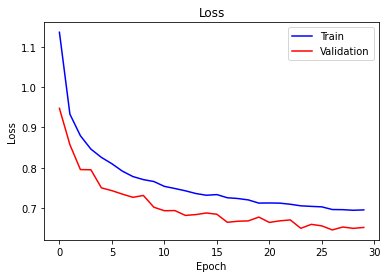

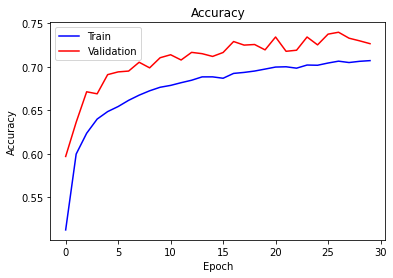

In [17]:
# Calculate the stat
curr_acc = st.mean(best_history.history['val_acc'][25:30]) 
print(curr_acc)

# Plot the fit history
plot_history(best_history)

In [18]:
# Get prediction report
y_pred = best_model.predict(val_X, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(val_y, y_pred_bool))

              precision    recall  f1-score   support

         0.0       0.58      0.50      0.53      1783
         1.0       0.80      0.89      0.84      1843
         2.0       0.94      0.89      0.91      1818
         3.0       0.59      0.62      0.60      1862

    accuracy                           0.73      7306
   macro avg       0.72      0.73      0.72      7306
weighted avg       0.72      0.73      0.72      7306



In [24]:
# Get the predictions of the test set given in /TestData
subject9_X = create_dataframe_X('TestData/subject_009_01__x.csv', 'TestData/subject_009_01__x_time.csv')
subject10_X = create_dataframe_X('TestData/subject_010_01__x.csv', 'TestData/subject_010_01__x_time.csv')
subject11_X = create_dataframe_X('TestData/subject_011_01__x.csv', 'TestData/subject_011_01__x_time.csv')
subject12_X = create_dataframe_X('TestData/subject_012_01__x.csv', 'TestData/subject_012_01__x_time.csv')

subject9_X = subject9_X.drop(columns = ['Time stamp'])
subject10_X = subject10_X.drop(columns = ['Time stamp'])
subject11_X = subject11_X.drop(columns = ['Time stamp'])
subject12_X = subject12_X.drop(columns = ['Time stamp'])

item_9_0 = subject9_X.iloc[0::4,].reset_index()
item_9_1 = subject9_X.iloc[1::4,].reset_index()
item_9_2 = subject9_X.iloc[2::4,].reset_index()
item_9_3 = subject9_X.iloc[3::4,].reset_index()
new_9_X = pd.concat([item_9_0, item_9_1, item_9_2, item_9_3], axis = 1, ignore_index = True)
new_9_X = new_9_X.dropna()
new_9_X = new_9_X.drop(columns = [0, 7, 14, 21])

item_10_0 = subject10_X.iloc[0::4,].reset_index()
item_10_1 = subject10_X.iloc[1::4,].reset_index()
item_10_2 = subject10_X.iloc[2::4,].reset_index()
item_10_3 = subject10_X.iloc[3::4,].reset_index()
new_10_X = pd.concat([item_10_0, item_10_1, item_10_2, item_10_3], axis = 1, ignore_index = True)
new_10_X = new_10_X.dropna()
new_10_X = new_10_X.drop(columns = [0, 7, 14, 21])

item_11_0 = subject11_X.iloc[0::4,].reset_index()
item_11_1 = subject11_X.iloc[1::4,].reset_index()
item_11_2 = subject11_X.iloc[2::4,].reset_index()
item_11_3 = subject11_X.iloc[3::4,].reset_index()
new_11_X = pd.concat([item_11_0, item_11_1, item_11_2, item_11_3], axis = 1, ignore_index = True)
new_11_X = new_11_X.dropna()
new_11_X = new_11_X.drop(columns = [0, 7, 14, 21])

item_12_0 = subject12_X.iloc[0::4,].reset_index()
item_12_1 = subject12_X.iloc[1::4,].reset_index()
item_12_2 = subject12_X.iloc[2::4,].reset_index()
item_12_3 = subject12_X.iloc[3::4,].reset_index()
new_12_X = pd.concat([item_12_0, item_12_1, item_12_2, item_12_3], axis = 1, ignore_index = True)
new_12_X = new_12_X.dropna()
new_12_X = new_12_X.drop(columns = [0, 7, 14, 21])

# Reshaping input for CNN
new_9_X = np.expand_dims(new_9_X, axis = 2)
new_10_X = np.expand_dims(new_10_X, axis = 2)
new_11_X = np.expand_dims(new_11_X, axis = 2)
new_12_X = np.expand_dims(new_12_X, axis = 2)

In [33]:
# Subject 9 Predictions
subject9_predictions = best_model.predict(new_9_X, batch_size=64, verbose=0)
subject9_pred_bool = np.argmax(subject9_predictions, axis=1)

# Subject 10 Predictions
subject10_predictions = best_model.predict(new_10_X, batch_size=64, verbose=0)
subject10_pred_bool = np.argmax(subject10_predictions, axis=1)

# Subject 11 Predictions
subject11_predictions = best_model.predict(new_11_X, batch_size=64, verbose=0)
subject11_pred_bool = np.argmax(subject11_predictions, axis=1)

# Subject 12 Predictions
subject12_predictions = best_model.predict(new_12_X, batch_size=64, verbose=0)
subject12_pred_bool = np.argmax(subject12_predictions, axis=1)

In [34]:
# Saving results to CSV
subject9 = pd.DataFrame(subject9_pred_bool)
subject9.to_csv('subject_009_01__y_prediction.csv')
subject10 = pd.DataFrame(subject10_pred_bool)
subject10.to_csv('subject_010_01__y_prediction.csv')
subject11 = pd.DataFrame(subject11_pred_bool)
subject11.to_csv('subject_011_01__y_prediction.csv')
subject12 = pd.DataFrame(subject12_pred_bool)
subject12.to_csv('subject_012_01__y_prediction.csv')